In [41]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import MeanShift, estimate_bandwidth 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from ridgeplot import ridgeplot
from scipy import stats
from scipy.stats import ttest_ind
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from pandas.plotting import parallel_coordinates

import warnings
warnings.filterwarnings('ignore')

In [42]:
# Synt1
# raw_data = pd.read_csv(r'..\Preprocessed_datasets\synt1_final.csv', index_col=0)
# raw_data.index = pd.RangeIndex(start=0, stop=2110, step=1)

# synt2
raw_data = pd.read_csv(r'..\Preprocessed_datasets\synt2_final.csv', index_col=0)
raw_data.index = pd.RangeIndex(start=0, stop=2350, step=1)

features = raw_data.drop(['errors'], axis=1)
# Number of errors
display(len(raw_data.loc[raw_data['errors']==1]))
display(len(raw_data.loc[raw_data['errors']==0]))
# display(raw_data)

790

1560

### Utils

In [43]:
def initialize_synthetic_data(raw_data, with_errors=True):
    """Initialisation of the theoretical dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

    new_data = raw_data.copy(deep=True)

    if with_errors:
        scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
        new_data['scaled_errors'] = new_data['errors'] * 0.8

    #if just_features:
    #    new_data = new_data.drop(['errors', 'class'], axis=1)

    #if scale_features:
    #    to_scale = raw_data.drop(['errors', 'class'], axis=1).columns
    #    new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    #if with_classes:
    #    for col in ['errors']:
    #        new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def plot_clusters(data, title, alpha):
    """This function returns a scatterplot of the clusters"""
    data.rename(columns={'x1' :'Feature 1'}, inplace=True )
    data.rename(columns={'x2':'Feature 2'}, inplace=True )
    # scatterplot = sns.scatterplot(data=data, x='x', y='y', alpha=0.8, hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    scatterplot = sns.scatterplot(data=data, x='Feature 1', y='Feature 2', alpha=alpha, hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    plt.show()

In [44]:
# def pca_plot(data):
#     pca_features = data.drop(['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters'], axis=1)
#     other_features = data[['scaled_errors', 'predicted_class', 'true_class', 'errors', 'clusters', 'new_clusters']]

#     df = pd.DataFrame(pca_features)
#     pca = pd.DataFrame(PCA(n_components=2).fit_transform(df), index=df.index)

#     temp_dataset = pca.join(other_features, how='left')
#     temp_dataset.rename( columns={0 :'1st'}, inplace=True )
#     temp_dataset.rename( columns={1 :'2nd'}, inplace=True )
    
#     scatterplot = sns.scatterplot(data=temp_dataset, x='1st', y='2nd', hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
#     scatterplot.set_title('test')
#     plt.show()

# def initialize_dataset(raw_data, with_errors=True, just_features=True, scale_features=True, with_classes=True):
#     """Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
#     It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """

#     new_data = raw_data.copy(deep=True)

#     if with_errors:
#         scaling_factor = 0.8 #needs to be converted to scaling range [0.2 - 1.2]
#         new_data['scaled_errors'] = new_data['errors'] * 0.8

#     if just_features:
#         new_data = new_data.drop(['errors', 'class'], axis=1)

#     if scale_features:
#         to_scale = raw_data.drop(['errors', 'class'], axis=1).columns
#         new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
#     if with_classes:
#         for col in ['errors']:
#             new_data[col] = raw_data[col]

#     new_data['clusters'] = 0
#     new_data['new_clusters'] = -1
#     return new_data

def get_random_cluster(clusters):
    """This function returns the value of a random cluster
    clusters Df.Column the column clusters"""
    result = -1
    while (result == -1):
        result = random.randint(0, len(clusters.unique()))
    return result

def accuracy(results):
    """This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" """ 
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    """ This function calculates the negative bias, which is the accuracy of the selected cluster - the accuracy of the remaining clusters 
    Cluster col: the name of the DF column where the cluster assignments are """
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. cluster ", cluster_id)
    return accuracy(cluster_x) - accuracy(remaining_clusters)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    """ This function calculates the negative bias, which is the accuracy of the selected cluster - the average accuracy
    Cluster col: the name of the DF column where the cluster assignments are """
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return accuracy(cluster_x) - ave_acc

def get_next_cluster(data):
    """ This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors" """
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    """ This function returns the absolute value of highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters """
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_negative_bias(fulldata, function=bias_acc):
    """ This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters  --> used for identifying underperformed clusters"""
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = (function(fulldata, cluster_number, "new_clusters")) # abs function
        if current_bias < max_abs_bias:
            print('current bias: ', current_bias)
            print('max abs bias: ', max_abs_bias)
            max_abs_bias = current_bias
    return max_abs_bias

def get_max_bias_cluster(fulldata, function=bias_acc):
    """ This function returns the cluster linked to the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters """
    max_abs_bias = 100
    best_cluster = -2
    for cluster_number in fulldata['clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = function(fulldata, cluster_number, "clusters") # abs function
        print(f"{cluster_number} has bias {current_bias}")
        if current_bias < max_abs_bias:
            max_abs_bias = current_bias
            best_cluster = cluster_number
    return best_cluster

def calculate_variance(data):
    """This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg"""
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc(data, j, 'clusters') 
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def get_min_cluster_size(data):
    """Returns the size of the smallest new cluster"""
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

# 1. Hierarchical Bias-Aware MeanShift Clustering 

In [52]:
full_data = initialize_synthetic_data(raw_data)
#synt1
# full_data.index = pd.RangeIndex(start=0, stop=2110, step=1)

#synt2
full_data.index = pd.RangeIndex(start=0, stop=2350, step=1)

bandwidth_features = full_data[['x1', 'x2', 'scaled_errors']]
bw1 = estimate_bandwidth(bandwidth_features) #with quantile?
bw1

5.295803279155719

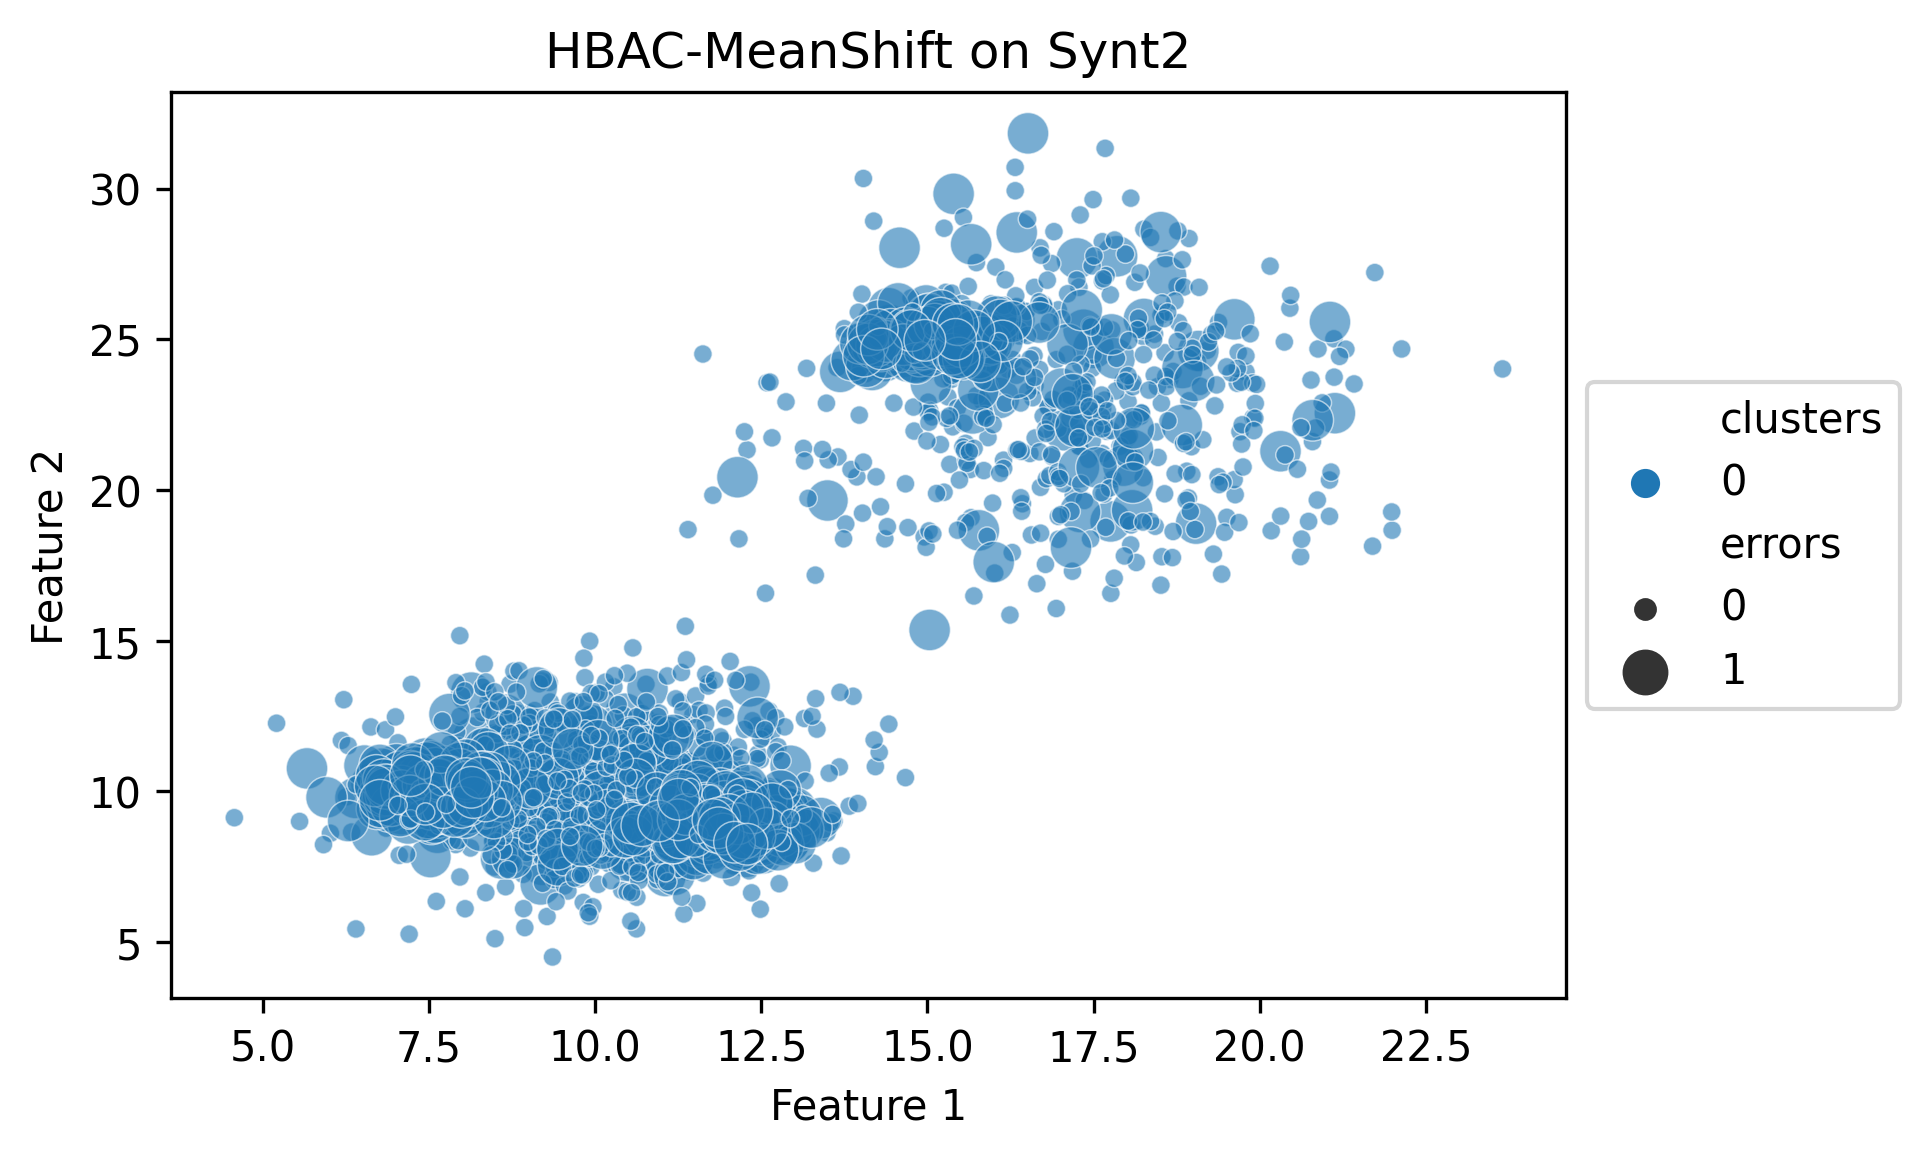

smallest cluster: 252
CHECK!


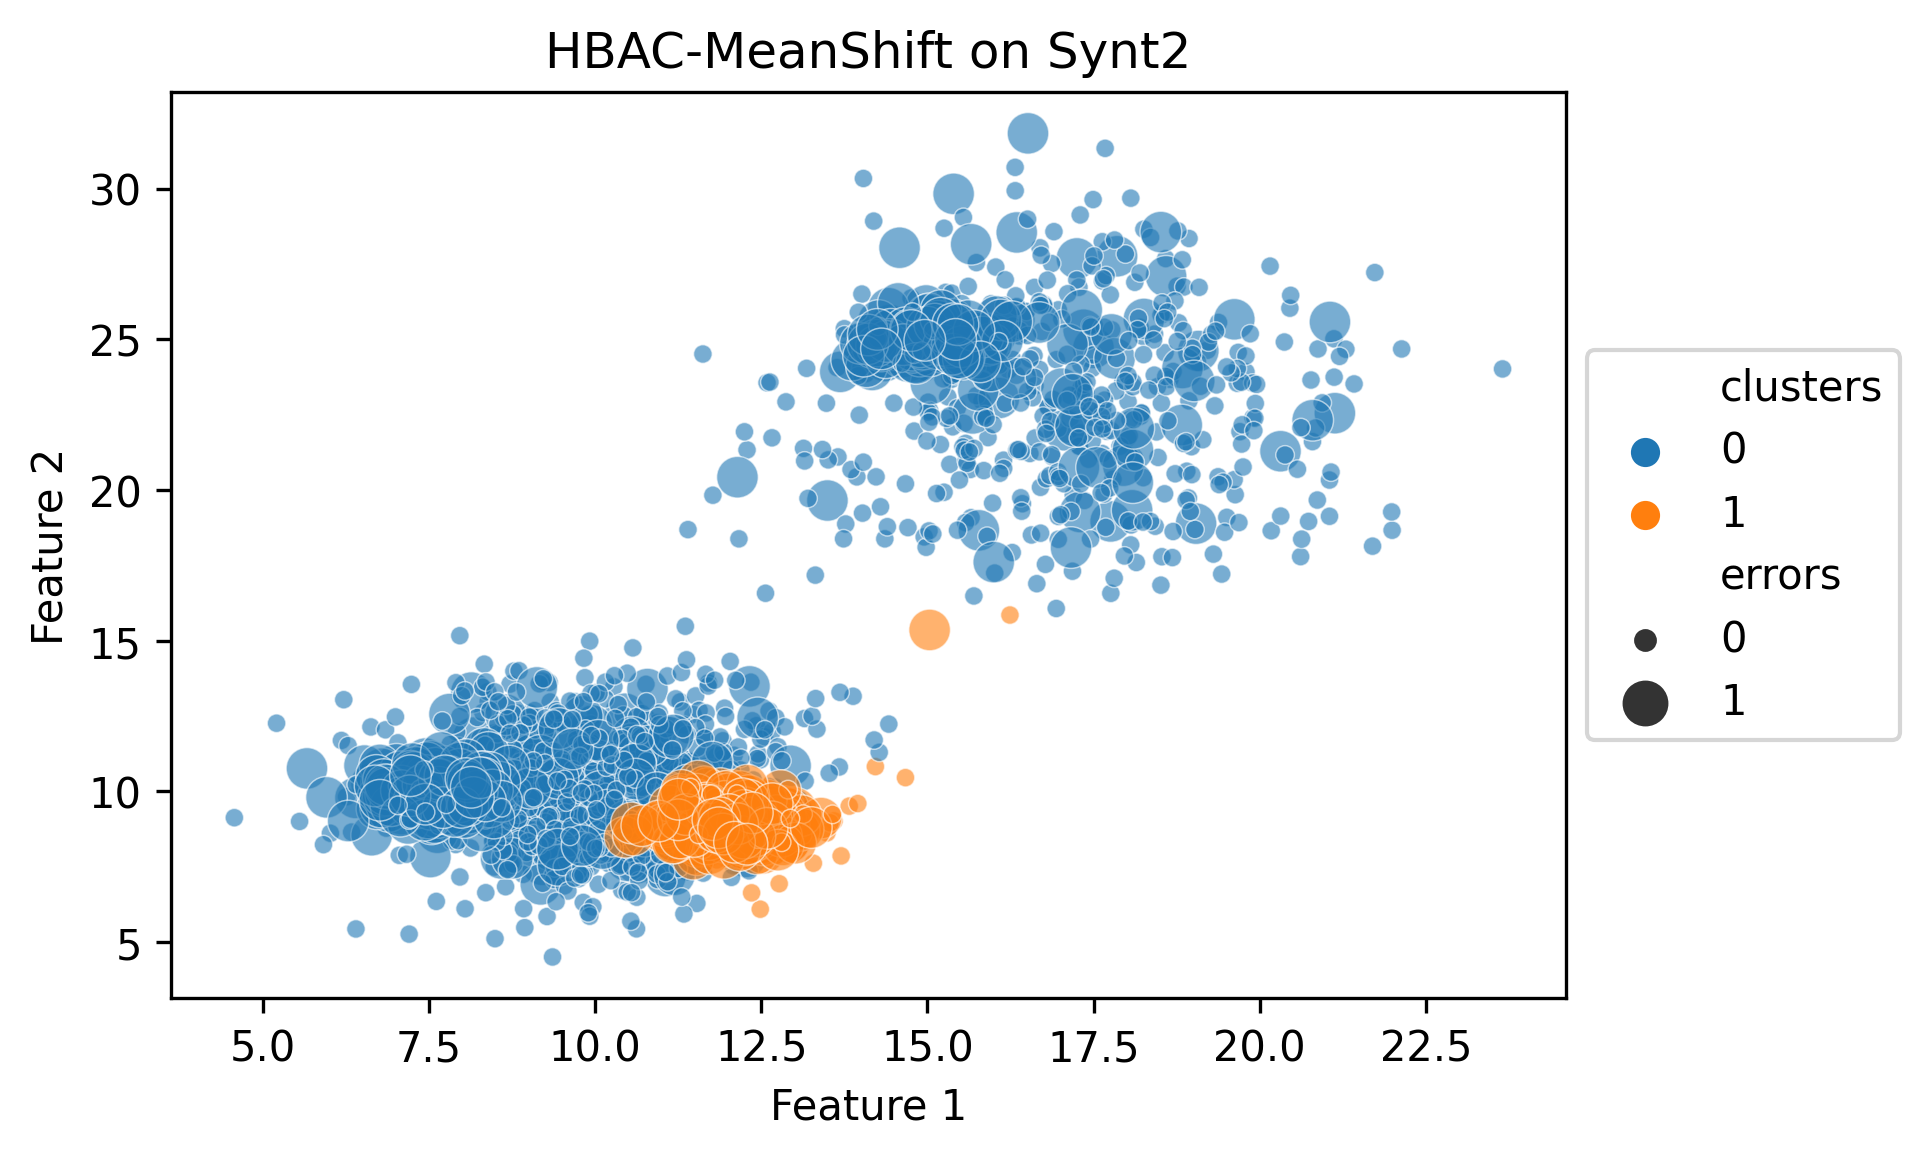

--> Cluster with the highest variance: 1
smallest cluster: 2
smallest cluster: 2
smallest cluster: 2
smallest cluster: 252
CHECK!


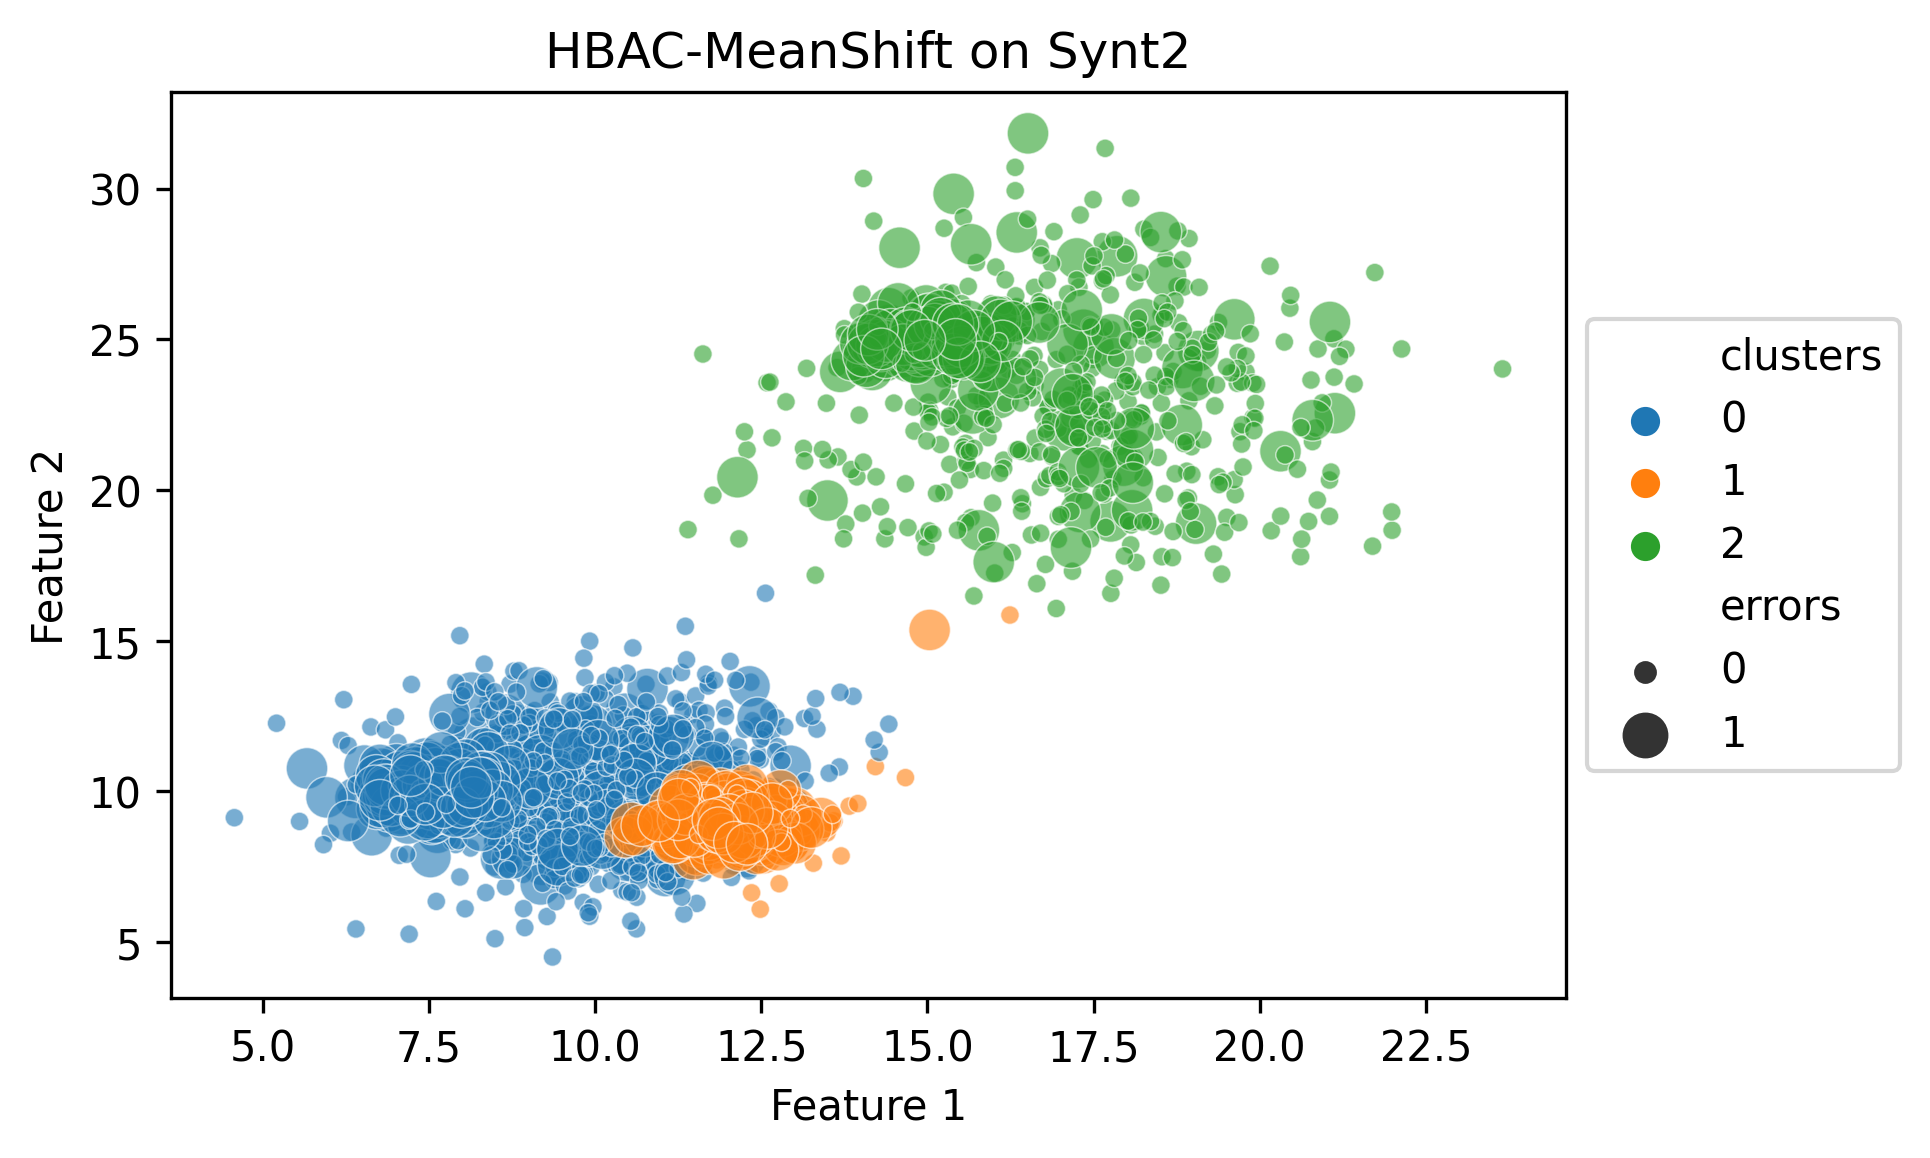

--> Cluster with the highest variance: 1
smallest cluster: 2
smallest cluster: 252
CHECK!


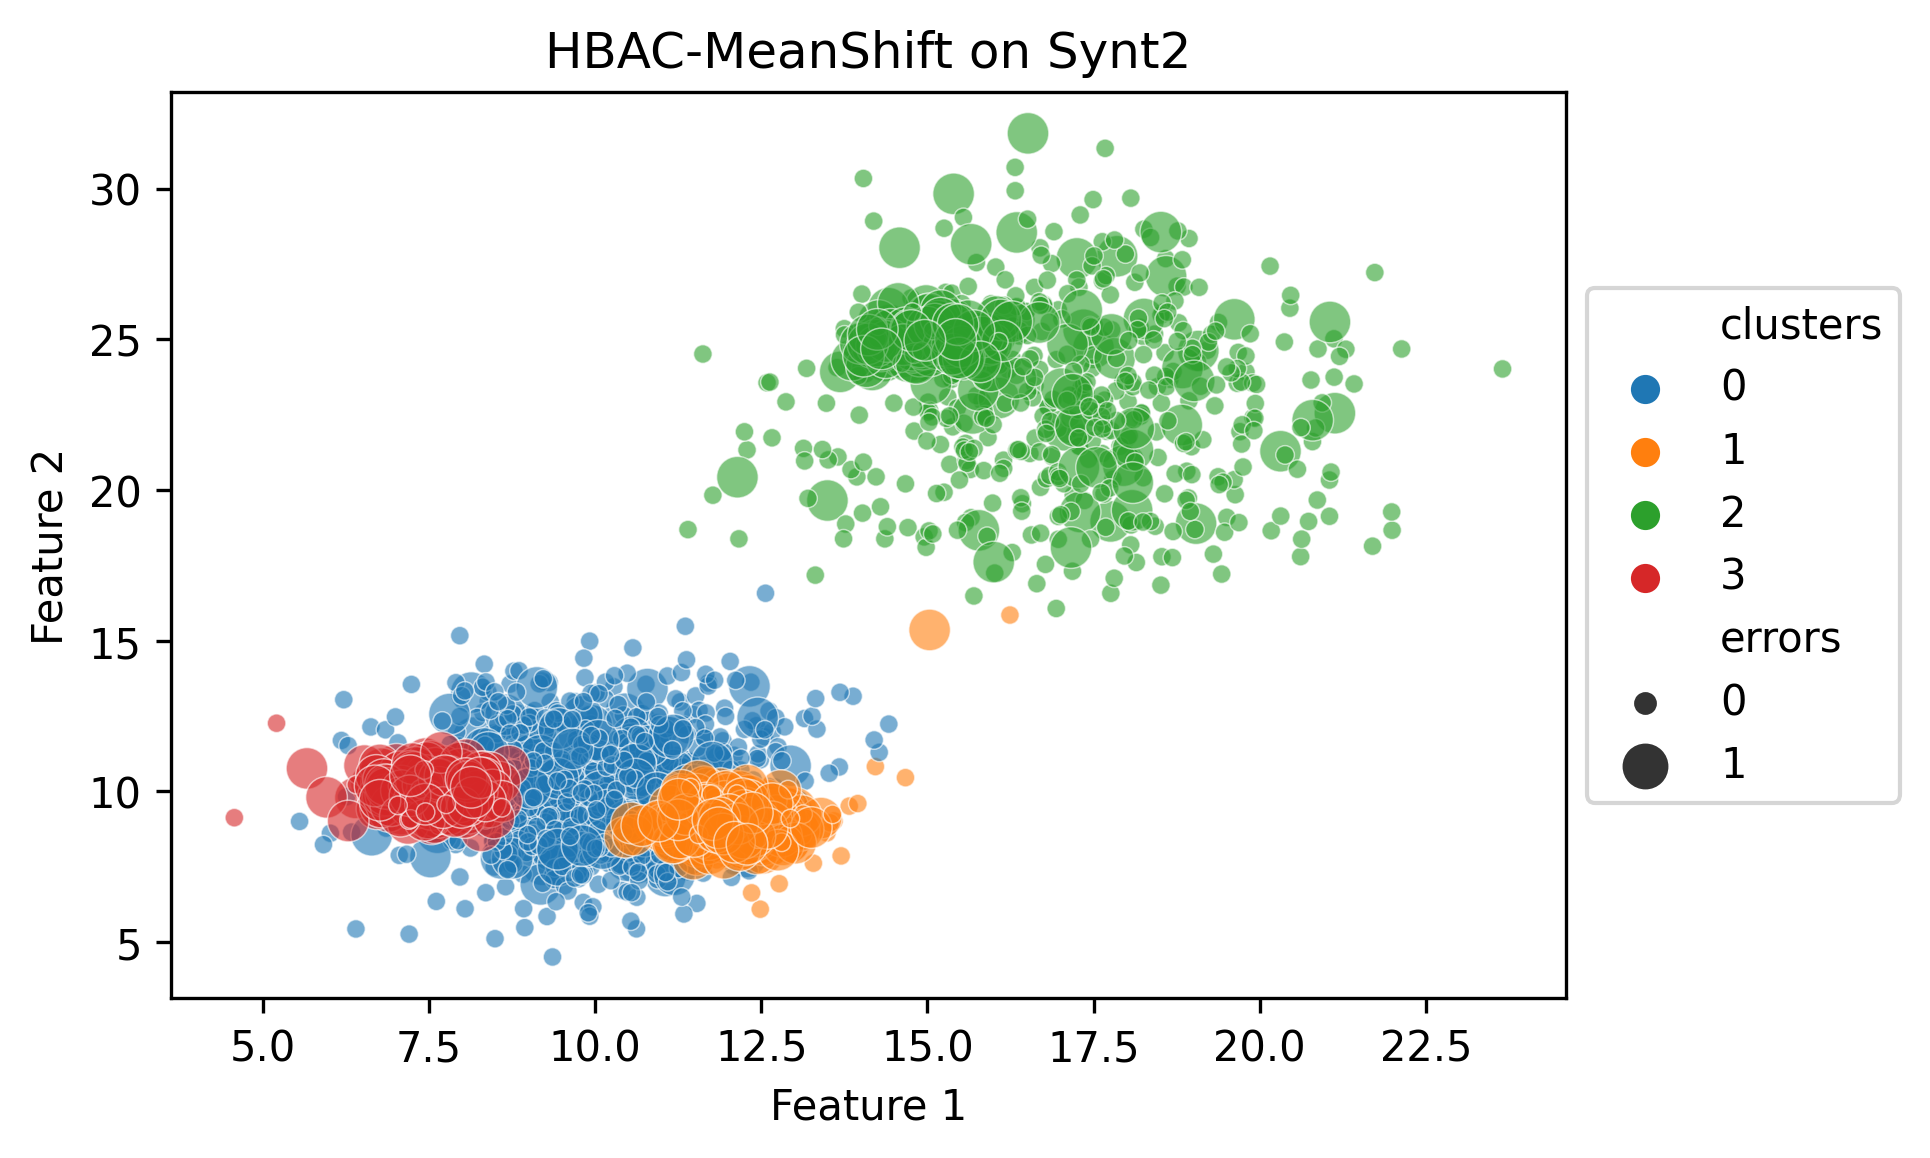

--> Cluster with the highest variance: 1
smallest cluster: 2
smallest cluster: 2
smallest cluster: 2
smallest cluster: 1
smallest cluster: 2
smallest cluster: 2
smallest cluster: 985
CHECK!


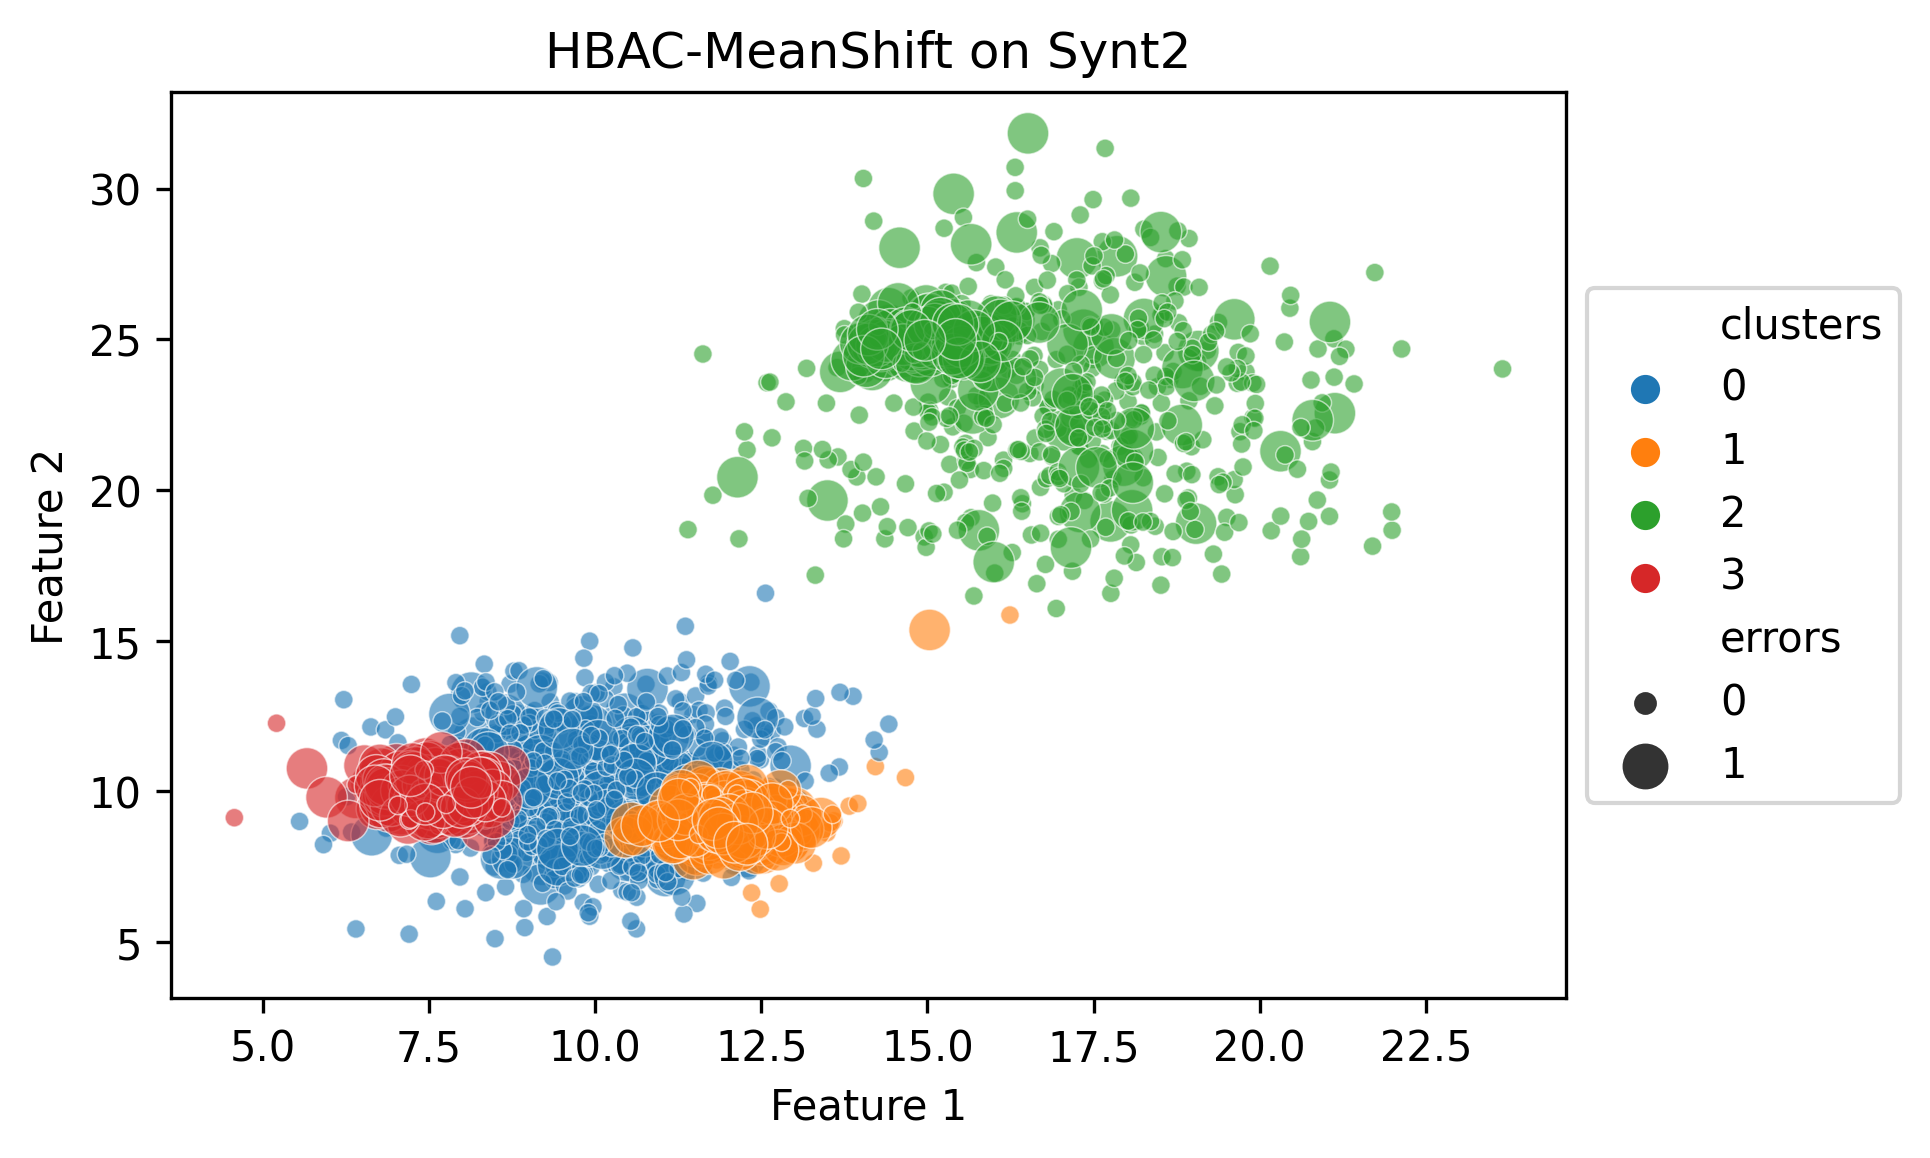

--> Cluster with the highest variance: 1
smallest cluster: 2
smallest cluster: 2
smallest cluster: 2
smallest cluster: 1
smallest cluster: 647
CHECK!


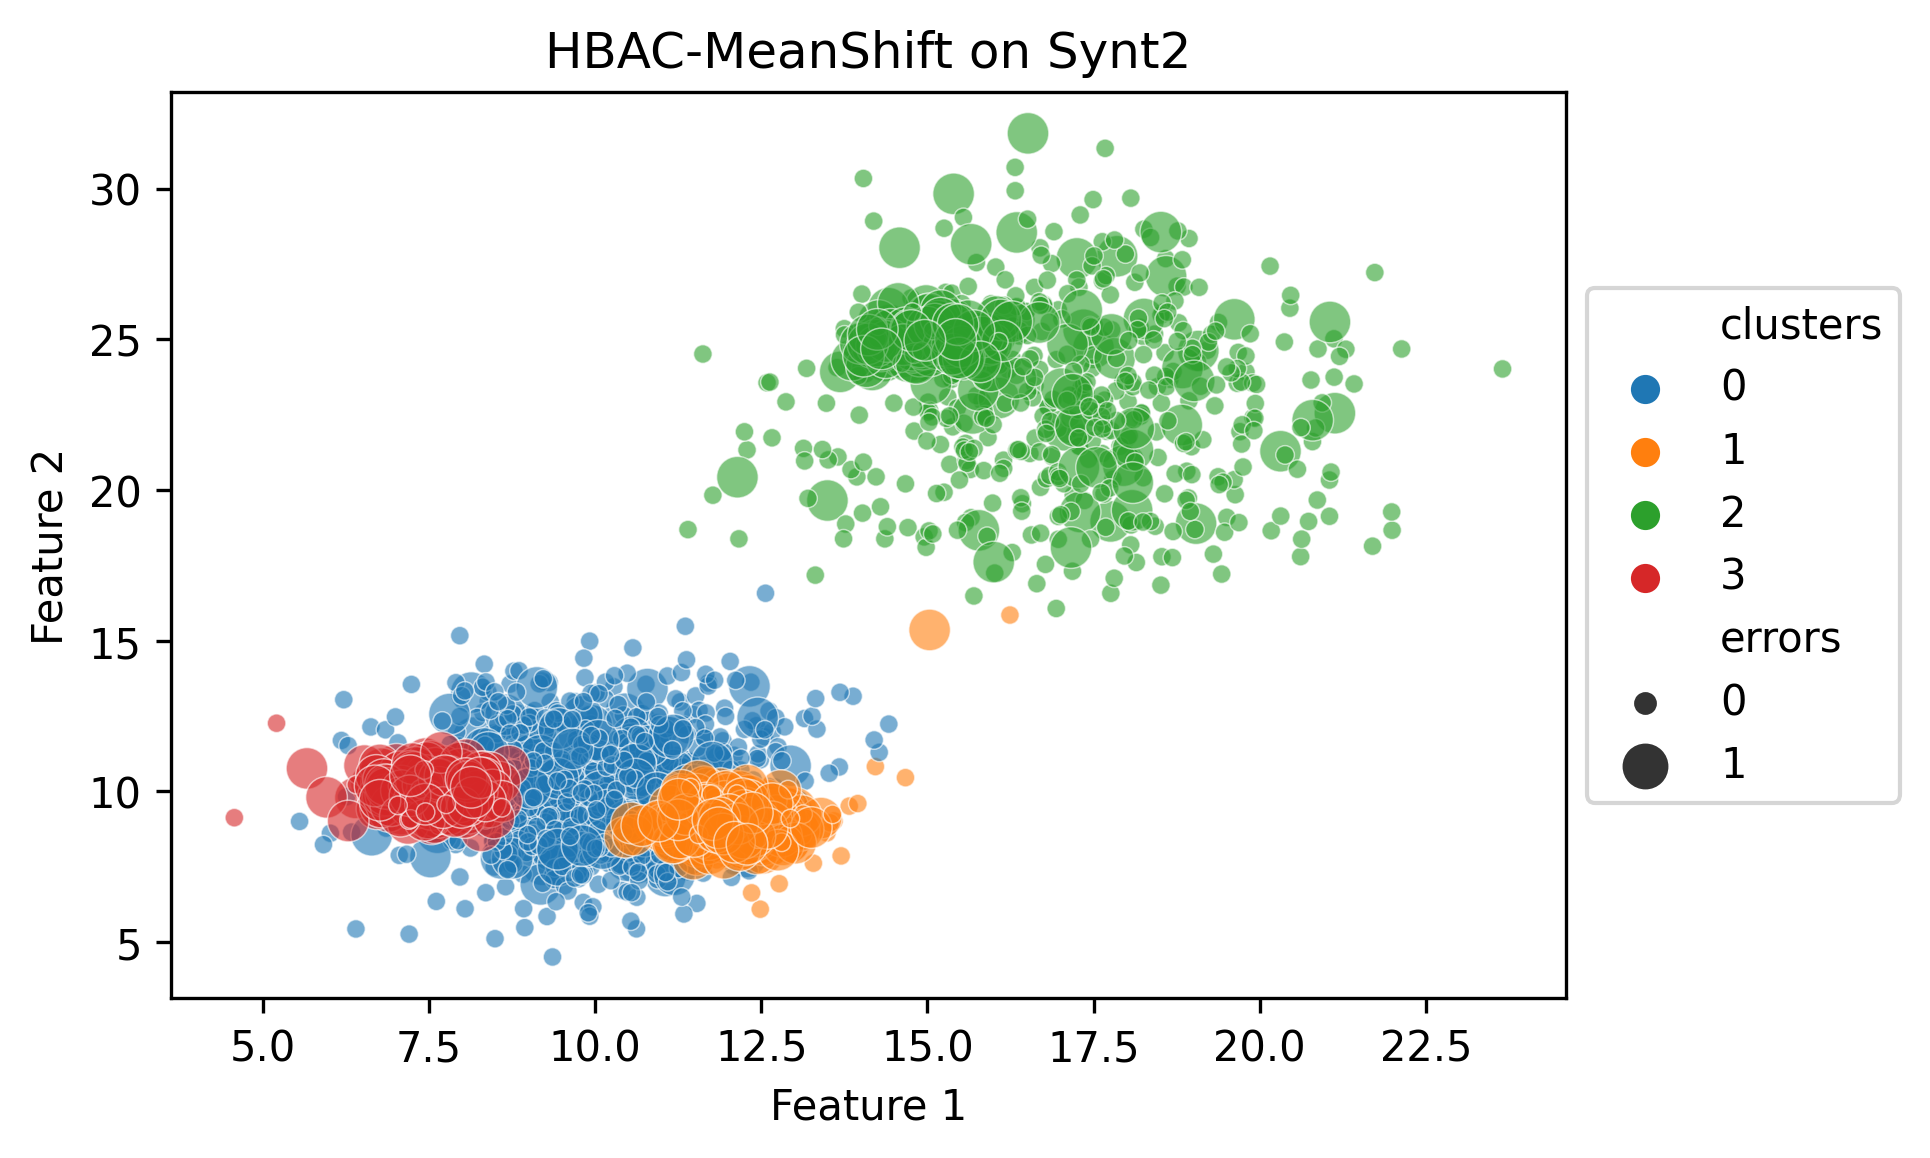

--> Cluster with the highest variance: 1
smallest cluster: 2
smallest cluster: 985
CHECK!


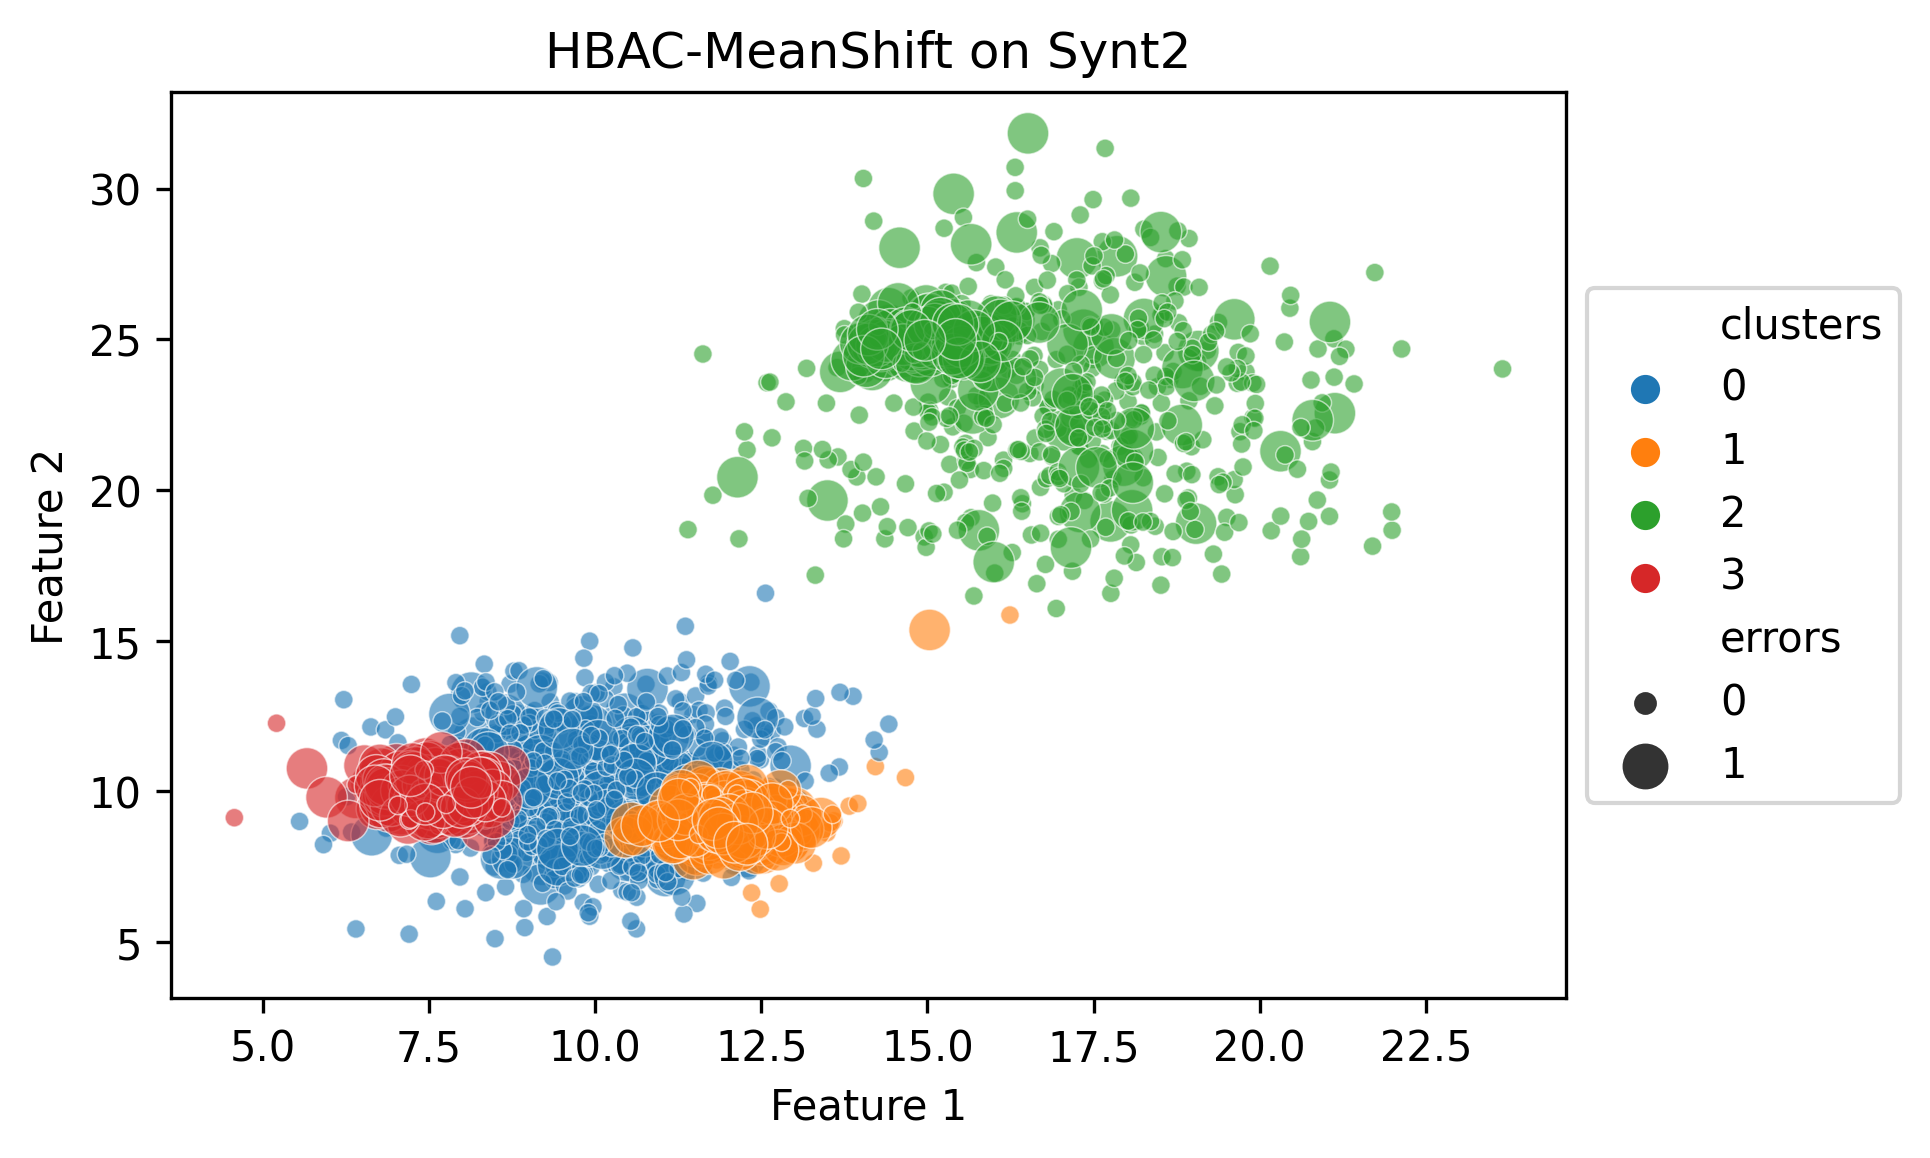

--> Cluster with the highest variance: 1
smallest cluster: 2
MAX_ITER
[0.2030490170912653, 0.2030490170912653, 0.2030490170912653, 0.2030490170912653, 0.2030490170912653, 0.2030490170912653, 0.0837876732893159, 0.0837876732893159, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497, 0.1224372485397497]


In [53]:
MAX_ITER = 30
x = 0 # cluster number
initial_bias = 0
bw1 = 3

plot_clusters(full_data, 'HBAC-MeanShift on Synt2', 0.6)
variance_list = []
minimal_splittable_cluster_size = round(0.05 * len(full_data))
minimal_acceptable_cluster_size = round(0.03 * len(full_data))
# print("average_accuracy is: ", average_accuracy) 


for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply MeanShift
    candidate_cluster['new_clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters']) 

    max_abs_bias = get_max_negative_bias(full_data) #get max abs bias
    min_new_size = get_min_cluster_size(full_data)
    print("smallest cluster:",min_new_size)
    if (max_abs_bias <= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): 
        print("CHECK!")
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        plot_clusters(full_data, 'HBAC-MeanShift on Synt2', 0.6)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

## Analysing the biased cluster

In [55]:
# Goal 1: Identifying highest biased cluster
c = get_max_bias_cluster(full_data)
highest_biased_cluster = full_data[full_data['clusters']==c]
len(highest_biased_cluster)

accuracy_full_data = accuracy(full_data)
most_biased_cluster_kmeans_aware = bias_acc(full_data, c, 'clusters')
full_data[full_data['clusters']==c]

print('General accuracy of classifier on this dataset:', accuracy_full_data)
# print('Number of clusters: ', full_data['clusters'].unique()) 
print(f"cluster {c} has the highest discrimination bias")
print(most_biased_cluster_kmeans_aware)

1 has bias -0.45060960607965883
0 has bias 0.3864933712649449
3 has bias -0.4101979209224204
2 has bias 0.08424990538562271
General accuracy of classifier on this dataset: 0.6638297872340425
cluster 1 has the highest discrimination bias
-0.45060960607965883


Number of instances in discriminated cluster: 466
Number of errors in discriminated clusters:  325
found discriminated cluster:


Feature 1  Feature 2  errors  class  scaled_errors  clusters  \
0     13.284373   7.619191       0      0            0.0         1   
11    12.485273   6.093399       0      0            0.0         1   
16    13.702090   7.861264       0      0            0.0         1   
72    13.595199   9.021702       0      0            0.0         1   
296   14.217202  10.824549       0      0            0.0         1   
...         ...        ...     ...    ...            ...       ...   
2095  11.924924   8.587157       1      3            0.8         1   
2096  11.772465   9.063997       1      3            0.8         1   
2097  11.858010   8.794638       1      3            0.8         1   
2098  12.097554   8.315909       1      3            0.8         1   
2099  12.285290   8.250387       1      3            0.8         1   

      new_clusters  
0              1.0  
11             1.0  
16             1.0  
72             1.0  
296            1.0  
...            ...  
2095           0.0  
2096           0.0  
2097           0.0  
2098           0.0  
2099           0.0  

[466 rows x 7 columns]

x1
this is the t-statistic 0.8924172179167458
this is the p-value: 0.3722670240549807
x2
this is the t-statistic -36.09532118933679
this is the p-value: 5.057687653075091e-221
errors
this is the t-statistic 19.169880672852702
this is the p-value: 7.773241458849366e-66
class
this is the t-statistic 49.43962270128817
this is the p-value: 0.0


unscaled_discriminated  unscaled_remaining  difference
x1                   12.056424           11.973928    0.082496
x2                    8.998059           14.656346   -5.658287
errors                0.697425            0.246815    0.450610
class                 2.901288            0.954352    1.946935

x1         x2    errors                   index
unscaled_discriminated  12.056424   8.998059  0.697425  unscaled_discriminated
unscaled_remaining      11.973928  14.656346  0.246815      unscaled_remaining

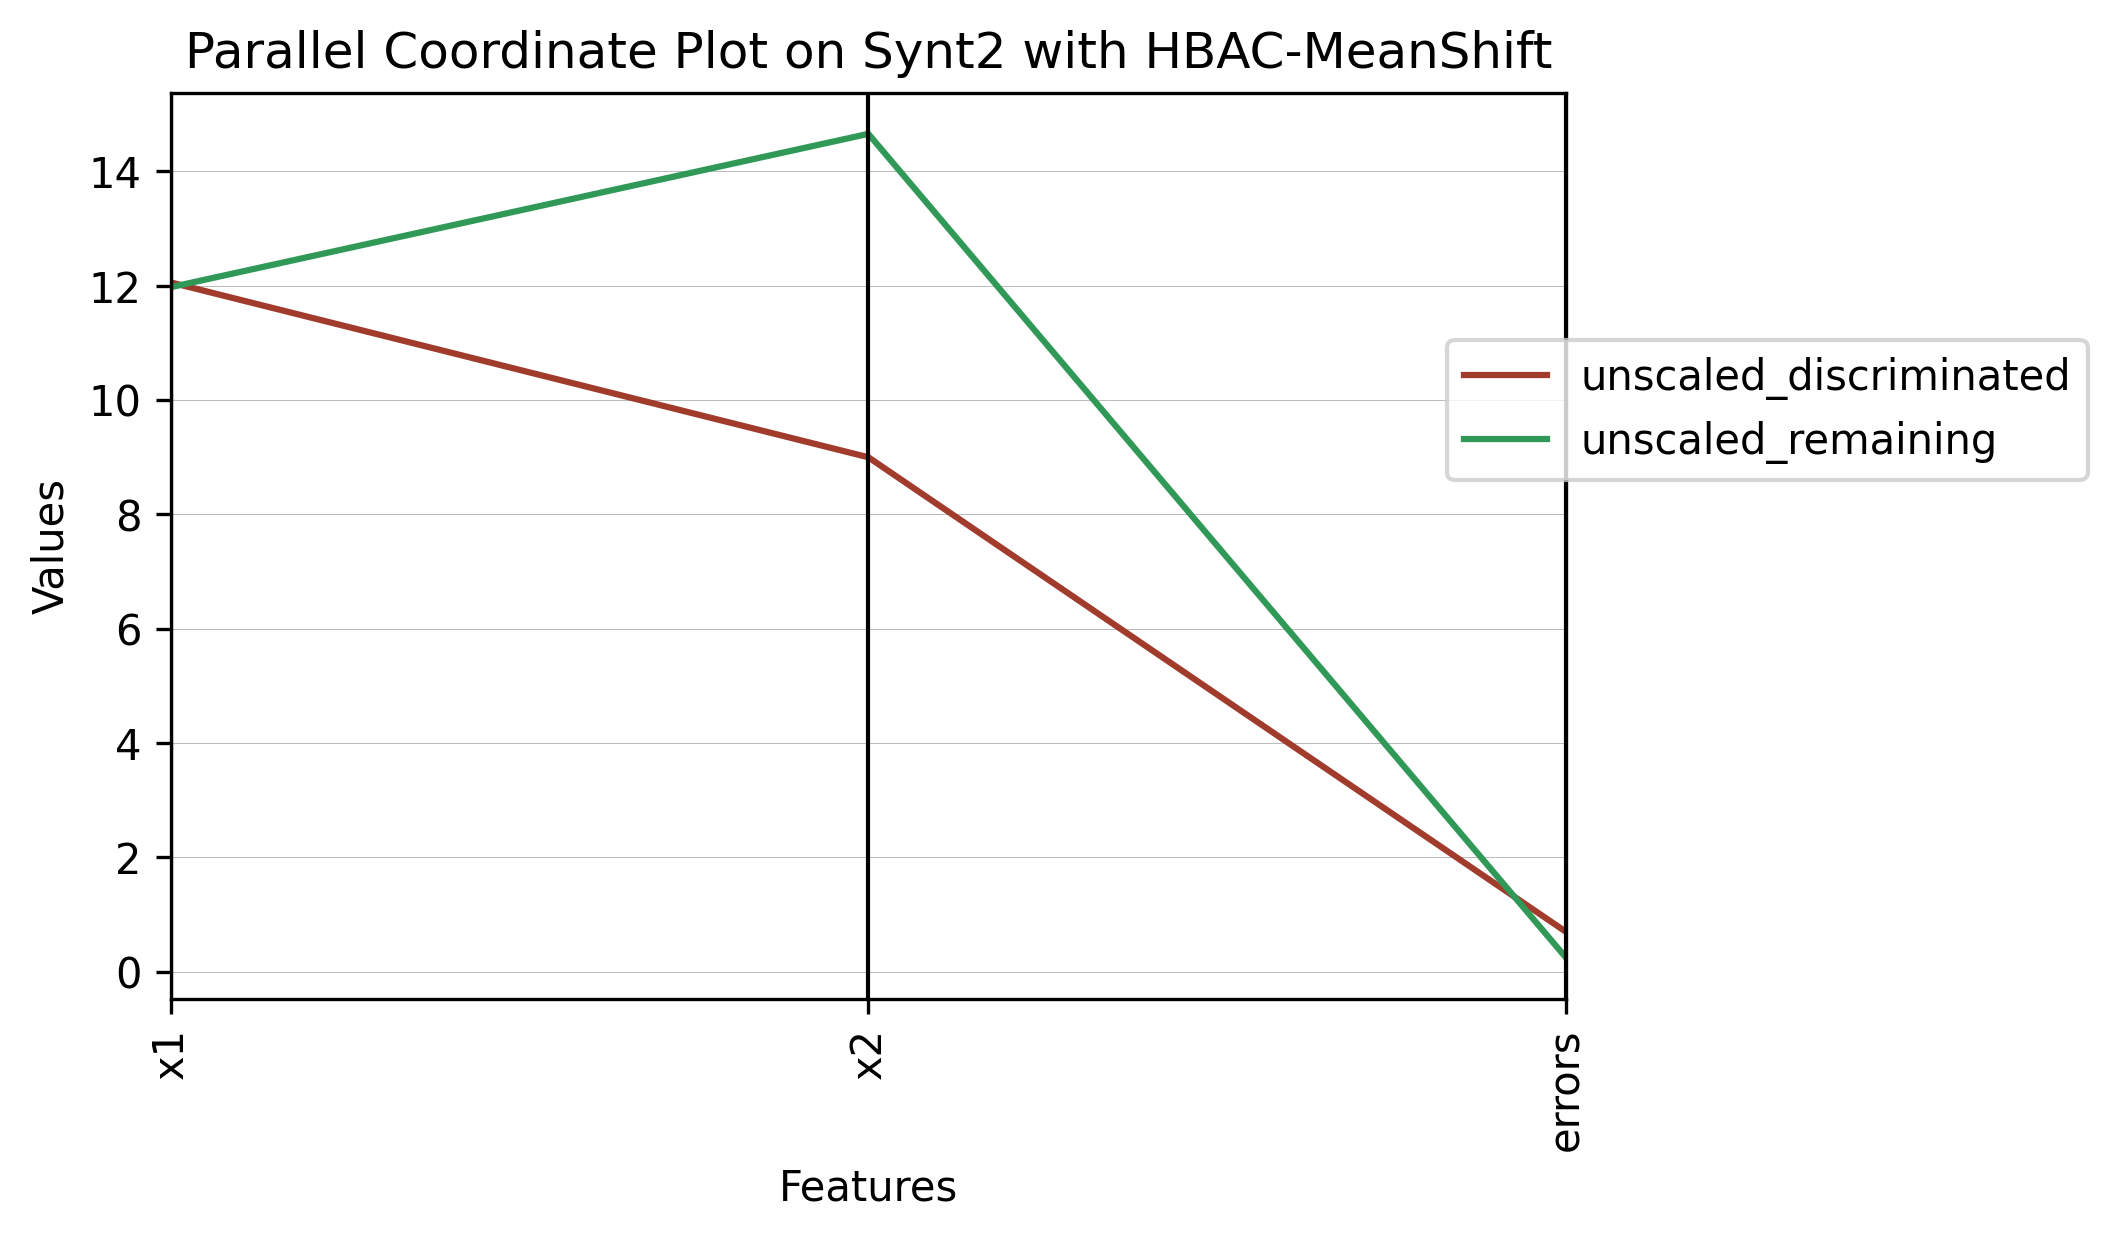

In [57]:
discriminated_cluster = full_data[full_data['clusters']==c]

# results 
print('Number of instances in discriminated cluster:', len(discriminated_cluster))
print('Number of errors in discriminated clusters: ', len(discriminated_cluster.loc[discriminated_cluster['errors']==1]))
print('found discriminated cluster:')
display(discriminated_cluster)

# unscaling the clusters
unscaled_discriminated = raw_data.loc[discriminated_cluster.index, :]
# unscaled other data
unscaled_remaining = raw_data.drop(discriminated_cluster.index)

# Welch's test 
for i in unscaled_remaining:
    welch_i = stats.ttest_ind(unscaled_discriminated[i], unscaled_remaining[i], equal_var=False)
    print(i)
    print('this is the t-statistic', welch_i.statistic)
    print('this is the p-value:', welch_i.pvalue)


# Creating DF with mean difference between features
mean_clusters = pd.DataFrame()
mean_clusters['unscaled_discriminated'] = unscaled_discriminated.mean()
mean_clusters['unscaled_remaining'] = unscaled_remaining.mean()
mean_clusters['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
display(mean_clusters)


# creating df for parallel coordinate plot
df_parallel = pd.DataFrame()
df_parallel['unscaled_discriminated'] = unscaled_discriminated.mean()
df_parallel['unscaled_remaining'] = unscaled_remaining.mean()
df_parallel = df_parallel.drop(['class'])
# df_parallel['difference'] = unscaled_discriminated.mean() - unscaled_remaining.mean()
df_parallel_transpose = df_parallel.T
df_parallel_transpose['index'] = df_parallel_transpose.index
display(df_parallel_transpose.head())

# create parallel coordinate plot
def create_parallel_coord_plot(copy_research_transpose, title):
    disc_plot = parallel_coordinates(copy_research_transpose, 'index', color= ('#a13c2d', '#319957'))
    plt.xticks(rotation=90)
    plt.legend(loc='upper left', bbox_to_anchor=(0.9,0.75)) 
    plt.xlabel("Features")
    plt.ylabel("Values")
    plt.grid(linewidth=0.2)
    plt.title(title)
    plt.show()

create_parallel_coord_plot(df_parallel_transpose, "Parallel Coordinate Plot on Synt2 with HBAC-MeanShift")

## Seaborn Density Plots

In [17]:
# df with discriminated and remaining clusters 

df_all = raw_data.copy(deep=True)
df_all["bias"] = "remaining"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

discriminated = df_all.loc[discriminated_cluster.index]
discriminated["bias"] = "discriminated"
df_all["bias"] = discriminated["bias"].combine_first(df_all['bias'])

# check to find discriminated instances in df
df_all.loc[df_all['bias']=='discriminated']


x1        x2  errors  class           bias
0    8.140322  3.875631       0      0  discriminated
1    7.651526  6.614556       0      0  discriminated
2    7.924532  2.980851       0      0  discriminated
3    7.748018  3.670137       0      0  discriminated
5    7.769980  3.095383       0      0  discriminated
..        ...       ...     ...    ...            ...
540  8.361846  1.337993       0      0  discriminated
541  7.945284  1.384610       0      0  discriminated
542  8.099856  3.667834       0      0  discriminated
543  7.954244  2.874513       1      0  discriminated
544  7.949300  3.990516       0      0  discriminated

[481 rows x 5 columns]

In [18]:
df_all.columns
welchtest = pd.DataFrame()
# welchtest = df_all[['Age', 'Job', 'Credit amount', 'Duration', 'bias']]
welchtest = df_all
welchtest.columns

Index(['x1', 'x2', 'errors', 'class', 'bias'], dtype='object')

1
2
3


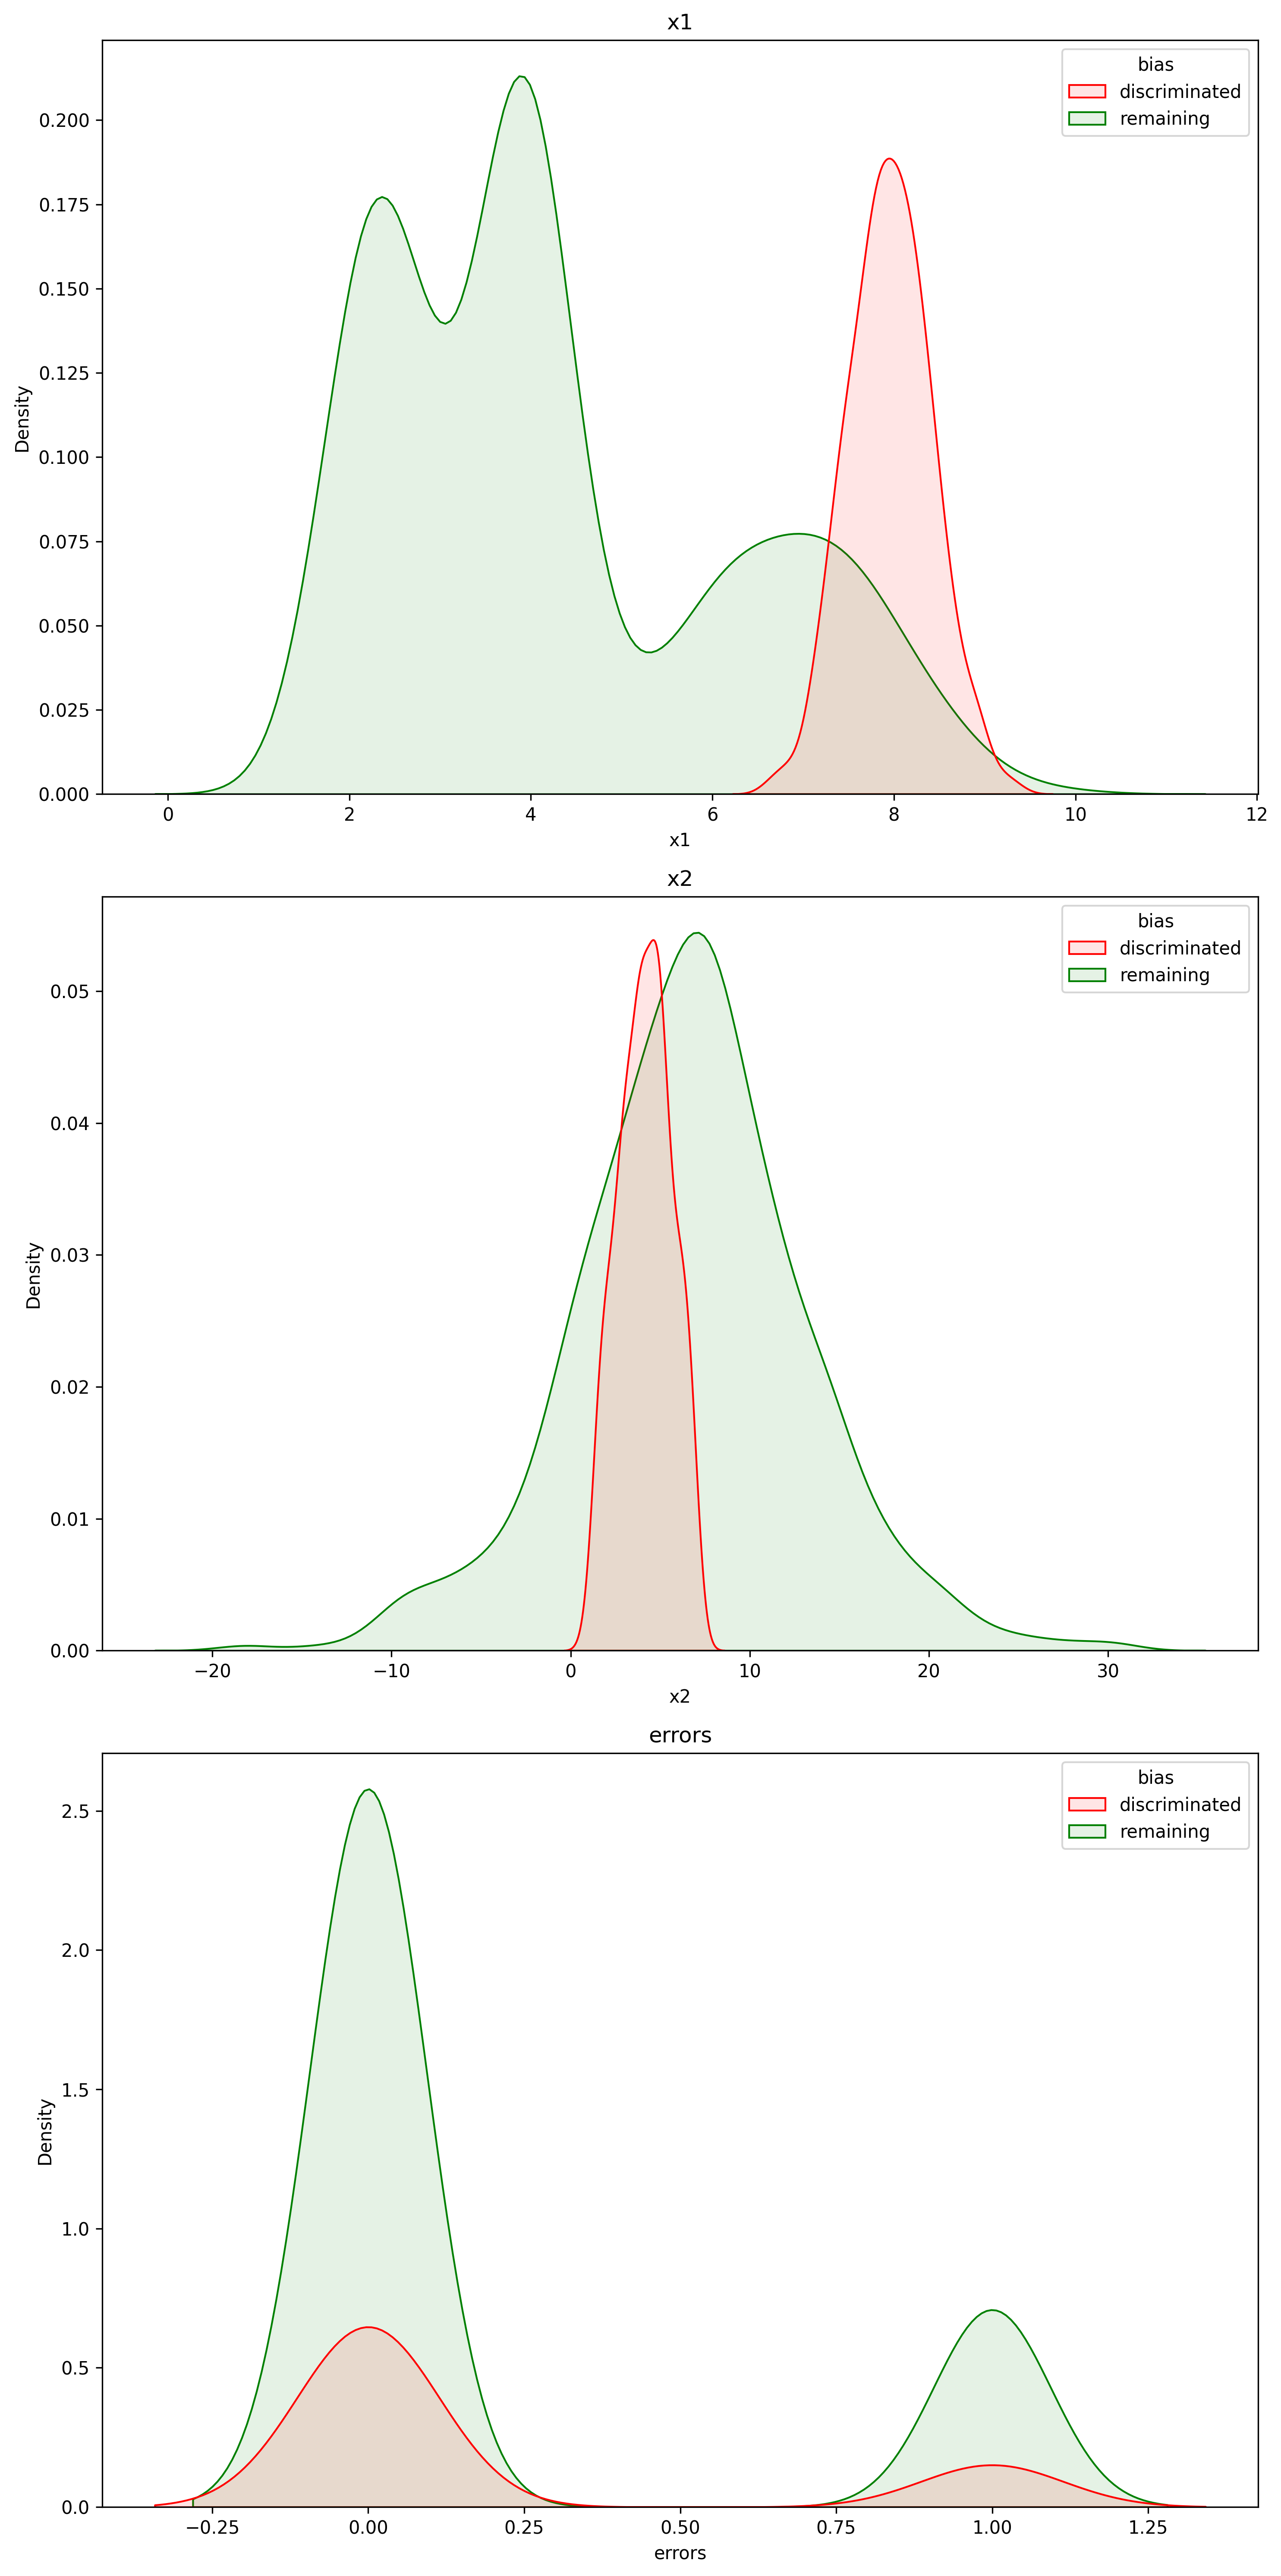

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,20))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in welchtest.columns:
    sns.kdeplot(data=welchtest, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 3: 
        break

plt.tight_layout()

plt.show()



In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# creating a dictionary with one specific color per group:
my_pal = {"remaining": "g", "discriminated": "r"}

i = 0
for col in welchtest.columns:
    sns.kdeplot(data=welchtest, x=col, shade=True, hue="bias", multiple='layer', ax=ax[i], palette=my_pal, alpha=0.1) # axis tweedimenionaal. Dus doorlopen met mod van i en / 5 naar beneden afgerond.
    ax[i].set_title(col, fontsize=12) # title niet overlappen, Grootte zelf bepalen. Maar 1 legenda 
    i += 1
    print(i) # dit en alles er onder moet uiteindelijk weg
    if i >= 2: 
        break

plt.tight_layout()

plt.show()


## Plotly 

In [ ]:
# df with discriminated and remaining clusters 

df_all = raw_data.copy(deep=True)
df_all["bias"] = "remaining"
#original_preprocessed[original_preprocessed.index in bias_index, "analysis_plot"] = "biased"

discriminated = df_all.loc[discriminated_cluster.index]
discriminated["bias"] = "discriminated"
df_all["bias"] = discriminated["bias"].combine_first(df_all['bias'])

# check to find discriminated instances in df
df_all.loc[df_all['bias']=='discriminated']


In [ ]:
import plotly.figure_factory as ff
import numpy as np

x1 = np.random.randn(200)
x2 = np.random.randn(200) + 2

group_labels = ['Group 1', 'Group 2']

colors = ['slategray', 'magenta']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot([x1, x2], group_labels, bin_size=.5,
                         curve_type='normal', # override default 'kde'
                         colors=colors)

# Add title
fig.update_layout(title_text='Distplot with Normal Distribution')
fig.show()

## Seaborn Pairplot / Density plot

In [ ]:
sns.pairplot(df_all, hue="bias")